# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
Задача: обучить модель классифицировать комментарии на позитивные и негативные. Имеется набор данных с разметкой о токсичности правок. Необходимо построить модель со значением метрики качества F1 не меньше 0.75.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Получение-данных" data-toc-modified-id="Получение-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Получение данных</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Чтение-данных-и-знакомство-с-ними" data-toc-modified-id="Чтение-данных-и-знакомство-с-ними-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Чтение данных и знакомство с ними</a></span></li><li><span><a href="#Определение-стоп-слов" data-toc-modified-id="Определение-стоп-слов-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Определение стоп-слов</a></span></li><li><span><a href="#Предварительная-обработка-текста" data-toc-modified-id="Предварительная-обработка-текста-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Предварительная обработка текста</a></span></li></ul></li><li><span><a href="#Подготовка-данных-для-модели-Bert" data-toc-modified-id="Подготовка-данных-для-модели-Bert-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных для модели Bert</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Функция-оценки-F1" data-toc-modified-id="Функция-оценки-F1-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Функция оценки F1</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Бустинг" data-toc-modified-id="Бустинг-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Бустинг</a></span></li><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Сравнение моделей</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

## Получение данных

### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#!pip install transformers
import transformers
from transformers import AutoTokenizer, AutoModel

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

import torch

from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Чтение данных и знакомство с ними

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

Отобразим первые 5 строк датафрейма.

In [3]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Отобразим общую инфомрацию о данных.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Мы получили таблицу данных с текстами комментариев и признаком токсичности (0 или 1). В таблице 159292 строк без пропусков. Комментарии написаны на английском языке. Посмотрим соотношение токсичных и нетоксичных слов в исходной таблице. 

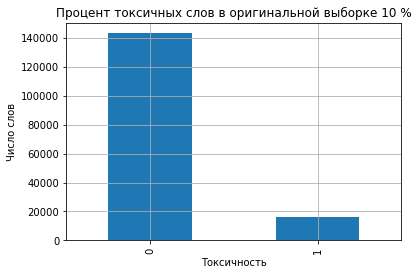

In [5]:
percent = round(df.query('toxic == 1').toxic.count() / df.shape[0] * 100)
df.groupby('toxic').toxic.count().plot.bar()
plt.title(f'Процент токсичных слов в оригинальной выборке {percent} %')
plt.ylabel('Число слов')
plt.xlabel('Токсичность')
plt.grid(True)
plt.show()

Для удобства вычислений возьмем небольшую выборку из таблицы, проверив, что соотношение токсичных и нетоксичных слов не изменится.

In [6]:
df = df.sample(1000, random_state = 12345).reset_index(drop=True)

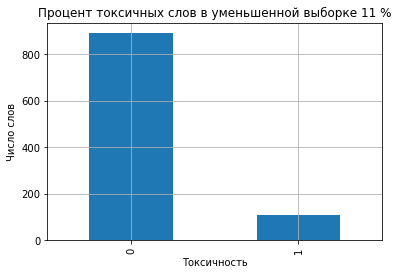

In [7]:
percent = round(df.query('toxic == 1').toxic.count() / df.shape[0] * 100)
df.groupby('toxic').toxic.count().plot.bar()
plt.title(f'Процент токсичных слов в уменьшенной выборке {percent} %')
plt.ylabel('Число слов')
plt.xlabel('Токсичность')
plt.grid(True)
plt.show()

Как видно на графике, распределение слов практически не изменилось. Для дальнешего исследования будем использовать эту уменьшенную выборку.

### Определение стоп-слов

In [8]:
# список стоп-слов
stop_words = set(stopwords.words('english'))

## Подготовка данных для модели Bert

В проекте используется модель Detoxify, обученная специально для предсказания токсичных слов.

In [9]:
# подгружаем предобученную модель токенизатора

model_id = 'unitary/toxic-bert'
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [10]:
tokenized = df['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))

max_len = len(max(tokenized, key=len))

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [11]:
model = AutoModel.from_pretrained(model_id)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
batch_size = 100
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

## Обучение

Обучающие признаки-эмбеддинги.

In [13]:
features = np.concatenate(embeddings)

Целевой признак.

In [14]:
target = df['toxic']
target = target.loc[tokenized.index]

Разделяем на обучающую и тестовую выборку и проверяем размерность получившихся выборок.

In [15]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=12345)

print('Размерность обучающей выборки - обучающие признаки x_train', x_train.shape)
print('Размерность тестовой выборки - обучающие признаки x_test', x_test.shape)
print('Размерность обучающей выборки - целевой признак y_train', y_train.shape)
print('Размерность обучающей выборки - целевой признак y_test', y_test.shape)

Размерность обучающей выборки - обучающие признаки x_train (800, 768)
Размерность тестовой выборки - обучающие признаки x_test (200, 768)
Размерность обучающей выборки - целевой признак y_train (800,)
Размерность обучающей выборки - целевой признак y_test (200,)


## Функция оценки F1

Определям функцию оценки моделей - f1.

In [16]:
def score_func(y_true, y_pred):
    score = f1_score(y_true, y_pred)
    return score

scorer = make_scorer(score_func)

## Логистическая регрессия

In [17]:
grid_lr = {
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

In [18]:
lr_cv = GridSearchCV(estimator=LogisticRegression(), param_grid=grid_lr, scoring=scorer, verbose=10)
lr_cv.fit(x_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5; 1/21] START C=0.001, solver=lbfgs......................................
[CV 1/5; 1/21] END .......C=0.001, solver=lbfgs;, score=0.903 total time=   0.3s
[CV 2/5; 1/21] START C=0.001, solver=lbfgs......................................
[CV 2/5; 1/21] END .......C=0.001, solver=lbfgs;, score=0.909 total time=   0.0s
[CV 3/5; 1/21] START C=0.001, solver=lbfgs......................................
[CV 3/5; 1/21] END .......C=0.001, solver=lbfgs;, score=0.882 total time=   0.0s
[CV 4/5; 1/21] START C=0.001, solver=lbfgs......................................
[CV 4/5; 1/21] END .......C=0.001, solver=lbfgs;, score=0.813 total time=   0.0s
[CV 5/5; 1/21] START C=0.001, solver=lbfgs......................................
[CV 5/5; 1/21] END .......C=0.001, solver=lbfgs;, score=0.914 total time=   0.0s
[CV 1/5; 2/21] START C=0.001, solver=liblinear..................................
[CV 1/5; 2/21] END ...C=0.001, solver=liblinear

C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 3/21] END ........C=0.001, solver=saga;, score=0.903 total time=   0.8s
[CV 2/5; 3/21] START C=0.001, solver=saga.......................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 3/21] END ........C=0.001, solver=saga;, score=0.909 total time=   0.8s
[CV 3/5; 3/21] START C=0.001, solver=saga.......................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 3/21] END ........C=0.001, solver=saga;, score=0.882 total time=   0.8s
[CV 4/5; 3/21] START C=0.001, solver=saga.......................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 3/21] END ........C=0.001, solver=saga;, score=0.813 total time=   0.8s
[CV 5/5; 3/21] START C=0.001, solver=saga.......................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 3/21] END ........C=0.001, solver=saga;, score=0.914 total time=   0.8s
[CV 1/5; 4/21] START C=0.01, solver=lbfgs.......................................
[CV 1/5; 4/21] END ........C=0.01, solver=lbfgs;, score=0.970 total time=   0.0s
[CV 2/5; 4/21] START C=0.01, solver=lbfgs.......................................
[CV 2/5; 4/21] END ........C=0.01, solver=lbfgs;, score=0.914 total time=   0.0s
[CV 3/5; 4/21] START C=0.01, solver=lbfgs.......................................
[CV 3/5; 4/21] END ........C=0.01, solver=lbfgs;, score=0.944 total time=   0.0s
[CV 4/5; 4/21] START C=0.01, solver=lbfgs.......................................
[CV 4/5; 4/21] END ........C=0.01, solver=lbfgs;, score=0.882 total time=   0.0s
[CV 5/5; 4/21] START C=0.01, solver=lbfgs.......................................
[CV 5/5; 4/21] END ........C=0.01, solver=lbfgs;, score=0.889 total time=   0.0s
[CV 1/5; 5/21] START C=0.01, solver=liblinear...................................
[CV 1/5; 5/21] END ....C=0.0

C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 6/21] END .........C=0.01, solver=saga;, score=0.941 total time=   0.7s
[CV 2/5; 6/21] START C=0.01, solver=saga........................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 6/21] END .........C=0.01, solver=saga;, score=0.914 total time=   0.7s
[CV 3/5; 6/21] START C=0.01, solver=saga........................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 6/21] END .........C=0.01, solver=saga;, score=0.944 total time=   0.7s
[CV 4/5; 6/21] START C=0.01, solver=saga........................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 6/21] END .........C=0.01, solver=saga;, score=0.882 total time=   0.8s
[CV 5/5; 6/21] START C=0.01, solver=saga........................................
[CV 5/5; 6/21] END .........C=0.01, solver=saga;, score=0.889 total time=   0.1s
[CV 1/5; 7/21] START C=0.1, solver=lbfgs........................................
[CV 1/5; 7/21] END .........C=0.1, solver=lbfgs;, score=0.941 total time=   0.0s
[CV 2/5; 7/21] START C=0.1, solver=lbfgs........................................
[CV 2/5; 7/21] END .........C=0.1, solver=lbfgs;, score=0.941 total time=   0.0s
[CV 3/5; 7/21] START C=0.1, solver=lbfgs........................................
[CV 3/5; 7/21] END .........C=0.1, solver=lbfgs;, score=0.973 total time=   0.0s
[CV 4/5; 7/21] START C=0.1, solver=lbfgs........................................
[CV 4/5; 7/21] END .........C=0.1, solver=lbfgs;, score=0.882 total time=   0.0s
[CV 5/5; 7/21] START C=0.1, solver=lbfgs........................................
[CV 5/5; 7/21] END .........

C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[CV 3/5; 10/21] END ..........C=1, solver=lbfgs;, score=0.944 total time=   0.0s
[CV 4/5; 10/21] START C=1, solver=lbfgs.........................................
[CV 4/5; 10/21] END ..........C=1, solver=lbfgs;, score=0.882 total time=   0.0s
[CV 5/5; 10/21] START C=1, solver=lbfgs.........................................
[CV 5/5; 10/21] END ..........C=1, solver=lbfgs;, score=0.882 total time=   0.0s
[CV 1/5; 11/21] START C=1, solver=liblinear.....................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[CV 1/5; 11/21] END ......C=1, solver=liblinear;, score=0.941 total time=   0.0s
[CV 2/5; 11/21] START C=1, solver=liblinear.....................................
[CV 2/5; 11/21] END ......C=1, solver=liblinear;, score=0.941 total time=   0.0s
[CV 3/5; 11/21] START C=1, solver=liblinear.....................................
[CV 3/5; 11/21] END ......C=1, solver=liblinear;, score=0.944 total time=   0.0s
[CV 4/5; 11/21] START C=1, solver=liblinear.....................................
[CV 4/5; 11/21] END ......C=1, solver=liblinear;, score=0.882 total time=   0.0s
[CV 5/5; 11/21] START C=1, solver=liblinear.....................................
[CV 5/5; 11/21] END ......C=1, solver=liblinear;, score=0.882 total time=   0.0s
[CV 1/5; 12/21] START C=1, solver=saga..........................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 12/21] END ...........C=1, solver=saga;, score=0.941 total time=   0.7s
[CV 2/5; 12/21] START C=1, solver=saga..........................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 12/21] END ...........C=1, solver=saga;, score=0.941 total time=   0.7s
[CV 3/5; 12/21] START C=1, solver=saga..........................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 12/21] END ...........C=1, solver=saga;, score=0.944 total time=   0.8s
[CV 4/5; 12/21] START C=1, solver=saga..........................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 12/21] END ...........C=1, solver=saga;, score=0.882 total time=   0.7s
[CV 5/5; 12/21] START C=1, solver=saga..........................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

[CV 5/5; 12/21] END ...........C=1, solver=saga;, score=0.882 total time=   0.8s
[CV 1/5; 13/21] START C=10, solver=lbfgs........................................
[CV 1/5; 13/21] END .........C=10, solver=lbfgs;, score=0.941 total time=   0.0s
[CV 2/5; 13/21] START C=10, solver=lbfgs........................................
[CV 2/5; 13/21] END .........C=10, solver=lbfgs;, score=0.941 total time=   0.0s
[CV 3/5; 13/21] START C=10, solver=lbfgs........................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[CV 3/5; 13/21] END .........C=10, solver=lbfgs;, score=0.914 total time=   0.0s
[CV 4/5; 13/21] START C=10, solver=lbfgs........................................
[CV 4/5; 13/21] END .........C=10, solver=lbfgs;, score=0.882 total time=   0.0s
[CV 5/5; 13/21] START C=10, solver=lbfgs........................................
[CV 5/5; 13/21] END .........C=10, solver=lbfgs;, score=0.882 total time=   0.0s
[CV 1/5; 14/21] START C=10, solver=liblinear....................................
[CV 1/5; 14/21] END .....C=10, solver=liblinear;, score=0.941 total time=   0.0s
[CV 2/5; 14/21] START C=10, solver=liblinear....................................
[CV 2/5; 14/21] END .....C=10, solver=liblinear;, score=0.941 total time=   0.0s
[CV 3/5; 14/21] START C=10, solver=liblinear....................................
[CV 3/5; 14/21] END .....C=10, solver=liblinear;, score=0.914 total time=   0.0s
[CV 4/5; 14/21] START C=10, solver=liblinear....................................
[CV 4/5; 14/21] END .....C=1

C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 15/21] END ..........C=10, solver=saga;, score=0.941 total time=   0.7s
[CV 2/5; 15/21] START C=10, solver=saga.........................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 15/21] END ..........C=10, solver=saga;, score=0.941 total time=   0.7s
[CV 3/5; 15/21] START C=10, solver=saga.........................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 15/21] END ..........C=10, solver=saga;, score=0.944 total time=   0.7s
[CV 4/5; 15/21] START C=10, solver=saga.........................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 15/21] END ..........C=10, solver=saga;, score=0.882 total time=   0.7s
[CV 5/5; 15/21] START C=10, solver=saga.........................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

[CV 5/5; 15/21] END ..........C=10, solver=saga;, score=0.882 total time=   0.7s
[CV 1/5; 16/21] START C=100, solver=lbfgs.......................................
[CV 1/5; 16/21] END ........C=100, solver=lbfgs;, score=0.941 total time=   0.0s
[CV 2/5; 16/21] START C=100, solver=lbfgs.......................................
[CV 2/5; 16/21] END ........C=100, solver=lbfgs;, score=0.941 total time=   0.0s
[CV 3/5; 16/21] START C=100, solver=lbfgs.......................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[CV 3/5; 16/21] END ........C=100, solver=lbfgs;, score=0.914 total time=   0.0s
[CV 4/5; 16/21] START C=100, solver=lbfgs.......................................
[CV 4/5; 16/21] END ........C=100, solver=lbfgs;, score=0.882 total time=   0.0s
[CV 5/5; 16/21] START C=100, solver=lbfgs.......................................
[CV 5/5; 16/21] END ........C=100, solver=lbfgs;, score=0.882 total time=   0.0s
[CV 1/5; 17/21] START C=100, solver=liblinear...................................
[CV 1/5; 17/21] END ....C=100, solver=liblinear;, score=0.941 total time=   0.0s
[CV 2/5; 17/21] START C=100, solver=liblinear...................................
[CV 2/5; 17/21] END ....C=100, solver=liblinear;, score=0.941 total time=   0.0s
[CV 3/5; 17/21] START C=100, solver=liblinear...................................
[CV 3/5; 17/21] END ....C=100, solver=liblinear;, score=0.914 total time=   0.0s
[CV 4/5; 17/21] START C=100, solver=liblinear...................................
[CV 4/5; 17/21] END ....C=10

C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 18/21] END .........C=100, solver=saga;, score=0.941 total time=   0.8s
[CV 2/5; 18/21] START C=100, solver=saga........................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 18/21] END .........C=100, solver=saga;, score=0.941 total time=   0.8s
[CV 3/5; 18/21] START C=100, solver=saga........................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 18/21] END .........C=100, solver=saga;, score=0.944 total time=   0.8s
[CV 4/5; 18/21] START C=100, solver=saga........................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 18/21] END .........C=100, solver=saga;, score=0.882 total time=   0.7s
[CV 5/5; 18/21] START C=100, solver=saga........................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 18/21] END .........C=100, solver=saga;, score=0.882 total time=   0.7s
[CV 1/5; 19/21] START C=1000, solver=lbfgs......................................
[CV 1/5; 19/21] END .......C=1000, solver=lbfgs;, score=0.914 total time=   0.0s
[CV 2/5; 19/21] START C=1000, solver=lbfgs......................................
[CV 2/5; 19/21] END .......C=1000, solver=lbfgs;, score=0.941 total time=   0.0s
[CV 3/5; 19/21] START C=1000, solver=lbfgs......................................
[CV 3/5; 19/21] END .......C=1000, solver=lbfgs;, score=0.914 total time=   0.0s
[CV 4/5; 19/21] START C=1000, solver=lbfgs......................................
[CV 4/5; 19/21] END .......C=1000, solver=lbfgs;, score=0.882 total time=   0.0s
[CV 5/5; 19/21] START C=1000, solver=lbfgs......................................
[CV 5/5; 19/21] END .......C=1000, solver=lbfgs;, score=0.882 total time=   0.0s
[CV 1/5; 20/21] START C=1000, solver=liblinear..................................
[CV 1/5; 20/21] END ...C=100

C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 21/21] END ........C=1000, solver=saga;, score=0.941 total time=   0.7s
[CV 2/5; 21/21] START C=1000, solver=saga.......................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 21/21] END ........C=1000, solver=saga;, score=0.941 total time=   0.7s
[CV 3/5; 21/21] START C=1000, solver=saga.......................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 21/21] END ........C=1000, solver=saga;, score=0.944 total time=   0.6s
[CV 4/5; 21/21] START C=1000, solver=saga.......................................


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 21/21] END ........C=1000, solver=saga;, score=0.882 total time=   0.7s
[CV 5/5; 21/21] START C=1000, solver=saga.......................................
[CV 5/5; 21/21] END ........C=1000, solver=saga;, score=0.882 total time=   0.7s


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'solver': ['lbfgs', 'liblinear', 'saga']},
             scoring=make_scorer(score_func), verbose=10)

In [19]:
lr_cv.best_params_

{'C': 0.1, 'solver': 'lbfgs'}

In [20]:
lr_f1 = lr_cv.best_score_
print(lr_f1)

0.9253135488429607


## Случайный лес

In [21]:
grid = { 
    'n_estimators': [50, 100],
    'max_depth' : [5, 10, 15],
    'random_state' : [12345]
}

In [22]:
rf_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid, scoring=scorer, verbose=10)
rf_cv.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START max_depth=5, n_estimators=50, random_state=12345............
[CV 1/5; 1/6] END max_depth=5, n_estimators=50, random_state=12345;, score=0.970 total time=   0.2s
[CV 2/5; 1/6] START max_depth=5, n_estimators=50, random_state=12345............
[CV 2/5; 1/6] END max_depth=5, n_estimators=50, random_state=12345;, score=0.914 total time=   0.2s
[CV 3/5; 1/6] START max_depth=5, n_estimators=50, random_state=12345............
[CV 3/5; 1/6] END max_depth=5, n_estimators=50, random_state=12345;, score=0.944 total time=   0.2s
[CV 4/5; 1/6] START max_depth=5, n_estimators=50, random_state=12345............
[CV 4/5; 1/6] END max_depth=5, n_estimators=50, random_state=12345;, score=0.848 total time=   0.1s
[CV 5/5; 1/6] START max_depth=5, n_estimators=50, random_state=12345............
[CV 5/5; 1/6] END max_depth=5, n_estimators=50, random_state=12345;, score=0.857 total time=   0.2s
[CV 1/5; 2/6] START max_depth=5, n_

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15], 'n_estimators': [50, 100],
                         'random_state': [12345]},
             scoring=make_scorer(score_func), verbose=10)

In [23]:
rf_cv.best_params_

{'max_depth': 5, 'n_estimators': 100, 'random_state': 12345}

In [24]:
rf_f1 = rf_cv.best_score_
print(rf_f1)

0.9135064935064936


## Бустинг

In [25]:
params = {'learning_rate': [0.03],
          'max_depth': [2, 3, 4, 5, 10, 100],
          'num_leaves': [10, 100]
         }

In [26]:
lgbm_cv = GridSearchCV(estimator=LGBMClassifier(), param_grid=params, scoring=scorer, verbose=10)

In [27]:
lgbm_cv.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START learning_rate=0.03, max_depth=2, num_leaves=10.............
[CV 1/5; 1/12] END learning_rate=0.03, max_depth=2, num_leaves=10;, score=0.971 total time=   0.3s
[CV 2/5; 1/12] START learning_rate=0.03, max_depth=2, num_leaves=10.............
[CV 2/5; 1/12] END learning_rate=0.03, max_depth=2, num_leaves=10;, score=0.941 total time=   0.2s
[CV 3/5; 1/12] START learning_rate=0.03, max_depth=2, num_leaves=10.............
[CV 3/5; 1/12] END learning_rate=0.03, max_depth=2, num_leaves=10;, score=0.944 total time=   0.2s
[CV 4/5; 1/12] START learning_rate=0.03, max_depth=2, num_leaves=10.............
[CV 4/5; 1/12] END learning_rate=0.03, max_depth=2, num_leaves=10;, score=0.813 total time=   0.2s
[CV 5/5; 1/12] START learning_rate=0.03, max_depth=2, num_leaves=10.............
[CV 5/5; 1/12] END learning_rate=0.03, max_depth=2, num_leaves=10;, score=0.889 total time=   0.2s
[CV 1/5; 2/12] START learning_rate=0.03

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.03],
                         'max_depth': [2, 3, 4, 5, 10, 100],
                         'num_leaves': [10, 100]},
             scoring=make_scorer(score_func), verbose=10)

In [28]:
lgbm_cv.best_params_

{'learning_rate': 0.03, 'max_depth': 2, 'num_leaves': 10}

In [29]:
lgbm_f1 = lgbm_cv.best_score_
print(lgbm_f1)

0.9116876750700278


## Сравнение моделей

In [30]:
index = ['LogisticRegression', 'RandomForestClassifier', 'LGBMClassifier']
f1_list = [lr_f1, rf_f1, lgbm_f1]
result = pd.DataFrame({'F1':f1_list}, index=index)

In [31]:
display(result)

,F1
LogisticRegression,0.925314
RandomForestClassifier,0.913506
LGBMClassifier,0.911688


Лучший результат показала модель **LogisticRegression** *(f1 = 0.93)*. Далее проверим ее значение F1 на тестовой выборке.

## Тестирование

In [32]:
predicted_test = lr_cv.predict(x_test)
test_f1 = score_func(y_test, predicted_test)
print(test_f1)

0.9777777777777777


Полученное значение больше заданного в условии.

# Выводы

Мы получили таблицу данных с текстами комментариев и признаком токсичности (0 или 1). В таблице 159292 строк без пропусков. Комментарии написаны на английском языке.
10% слов в комментариях токсичны.

Мы уменьшили выборку до 1000 комментариев, чтобы упростить дальнейший расчет. В уменьшенной выборке соотношение токсичных и нетоксичных слов сохраняется.

В проекте мы использовали модель *Detoxify*, специально обученную для предсказания токсичных слов английского языка. Преобразовав текст в эмбеддинги, мы использовали их как обучающие признаки для моделей. Целевым признаком является столбце *toxic*.

Мы обучили три модели: логистическую регрессию, случайный лес и бустинг LightGBM, попробовав разные гиперпараметры. Все модели показали высокие результаты. Модель **LogisticRegression** была немного лучше остальных. Мы выбрали ее для проверки показателя *f1* на тестовой выборке.

В результате тестирования мы получили значение, превышающее заданное по условию (0.75). Из чего можно сделать вывод, что данную модель можно рекомендовать заказчику.